In [ ]:
"""The codes below give multiple graphical results of the research"""

In [5]:
import numpy as np
from numpy import *
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
import math
import emcee
import corner
import random
from IPython.display import display, Math
from scipy import stats
import getdist
from getdist import plots, MCSamples
from astropy import units as u
from gammapy.modeling.models import ExpCutoffPowerLawSpectralModel, Models, SkyModel, EBLAbsorptionNormSpectralModel, LogParabolaSpectralModel, BrokenPowerLawSpectralModel
from ebltable.tau_from_model import OptDepth
from matplotlib import cm
import matplotlib.cbook as cbook
import matplotlib.colors as colors
import pygtc
import scipy.optimize as opt
import sys
sys.path.append("/LHAASO_AGN_APL/AxionLimits_master/")
from AxionLimits_master.PlotFuncs import AxionPhoton, FigSetup, line_background, col_alpha
%matplotlib inline

In [2]:
"""Unit System & Warnings"""

# observed unit in TeV, cm, s, Gauss
# for ma and g: 
#       ma(presented) = ma(computed) * 10**(-6) eV  (i.e. in mueV)
#       g(presented) = g(computed) * 10**(-11) GeV-1

# Optdepth package can only read data up to 100 TeV, causing the spike in graph

'Unit System & Warnings'

In [2]:
# fundamental constant

# earth magnetic field 0.5*10**(-6) Gauss fitted by paper
# scale 4 kpc according to paper

c = 3 * 10**8     # speed of light
hbar = 1.054 * 10**(-34)    # Planck constant
epsilon = 8.854 * 10**(-12)   # electric permittivity
converter = (1*u.Unit('GeV-1 Gauss')).to(u.Unit('Joule-1 Tesla')).value     # convert g*B to SI unit
length = (1*u.kiloparsec).to(u.m).value     # from kpc to m

BE = (0.5*10**(-6) * u.Gauss).value  # earth magnetic field
rE = (4 * u.kiloparsec).value  # earth magnetic field scale

# dictionary for variable name and limit referencing
var_name_dict = {'g': r'$g_{\alpha\gamma}$', 'ma':r'$m_{a}$', 
                  'phin':r'$\phi_{0}$', 'alpha':r'$\alpha$', 'Ec':r'$E_{c}$', 
                  'beta': r'$\beta$', 'gamma1':r'$\Gamma_{1}$', 'gamma2':r'$\Gamma_{2}$', 'Ebreak':r'$E_{b}$'}
var_limit_dict = {'g':[0, 15], 'ma':[0, 15], 
                  'phin':[0, 50], 'alpha':[0, 20], 'Ec':[0, 200], 
                  'beta': [0, 50], 'gamma1':[0, 100], 'gamma2':[0, 100], 'Ebreak':[0, 100]}

In [4]:
# conversion probability by original paper
def psga(g, ma, B, r, E):
    # probability of photon-APL conversion at a place with B field and scale r, of energy E
    return (1/2) * (g *10**(-11) * B / osc(g, ma, B, E))**2 * (math.sin(osc(g, ma, B, E) * converter * r * length * c**(3/2) * hbar**(1/2) * epsilon**(1/2) / 2))**2

def psgg(g, ma, B, r, E):
    # probability of not converting
    return 1 - psga(g, ma, B, r, E)


def pgga(g, ma, E):
    # probability of photong converting to APL on Earth
    return psga(g, ma, BE, rE, E)

def pgag(g, ma, E):
    # probability of converting back to photon on Earth
    return 2 * pgga(g, ma, E)

def pggg(g, ma, E):
    # probability of not converting APL on Earth
    return 1 - pgga(g, ma, E)


def osc(g, ma, B, E):
    # oscillation term
    return g * 10**(-11) * B * (1 + (Ecrit(g, ma, B)/E + E/EH(g, B))**2)**(1/2)

def Ecrit(g, ma, B):
    # critical energy for conversion, in TeV unit
    return 38 * ma**2 * (10**(-5) / B) * (6.5/g)

def EH(g, B):
    # photon one-loop polarization, in TeV unit
    return 2.1 * 10**(2) * (10**(-5) / B) * g

In [3]:
# conversion probability calculation used


def deltagamma(g, B):

    # output: coupling term, in unit of kpc-1
    # g: axion coupling constant
    # B: galactic transverse  magnetic field

    return 3.1 * 10**(-2) * (g/2) * (B/(10**(-6)))


def delta(ma, E):

    # output: axion mass term, in unit of kpc-1
    # ma: axion mass
    # E: photon energy

    return -7.8 * 10**(-3) * (ma / (10**(-2)))**2 * (E)**(-1)


def deltpl(E):

    # output: elecron density term, in unit of kpc -1
    # E: photon energy

    return -1.1 * 10**(-10) * E**(-1)


def deltosc(g, ma, B, E):

    # output: oscillation wave number, in kpc-1
    # g: axion coupling constant
    # ma: axion mass
    # B: galactice transverse magnetic field
    # E: photon energy

    return ((deltpl(E) - delta(ma, E))**2 + 4 * deltagamma(g, B)**2)**(1/2)


def Pnot(g, ma, B, r, E):

    # output: probability of axion transmission within one region
    # g: axion coupling constant
    # ma: axion mass
    # B: galactic transverse magnetic field
    # r: length of scale of each region
    # E: photon energy

    return (deltagamma(g, B) * r)**2 * math.sin(deltosc(g, ma, B, E) * r / 2)**2 / (deltosc(g, ma, B, E) * r / 2)**2


def Psga(g, ma, B, r, E):

    # output: probability of conversion at source, separating all galaxies' magnetic field into 10 regions
    # g: axion coupling constant
    # ma: axion mass
    # B: galactic transverse magnetic field
    # r: length of scale of each region
    # E: photon energy

    return (1/3) * (1 - math.exp(-1.5 * 10 * Pnot(g, ma, B, r, E)))


def Psgg(g, ma, B, r, E):

    # output: probability of not converting at source
    # g: axion coupling constant
    # ma: axion mass
    # B: galactic transverse magnetic field
    # r: length of scale of each region
    # E: photon energy

    return 1 - Psga(g, ma, B, r, E)


def Pggg(g, ma, E):

    # output: probability of conversion at earth
    # g: axion coupling constant
    # ma: axion mass
    # E: photon energy

    return Psga(g, ma, BE, rE, E)


def Pgag(g, ma, E):

    # output: probability of back converstion at Earth
    # g: axion coupling constant
    # ma: axion mass
    # E: photon energy

    return 2*Psga(g, ma, BE, rE, E)

In [62]:
# Basic spectrum function using exponential cutoff

def PLC(phin, alpha, Ec, E0):

    # output: spectrum under PLC model
    # phin: normalization factor
    # alpha: decreasing power index
    # Ec: cutoff energy
    # E0: reference energy, set as 1 TeV according to paper

    return ExpCutoffPowerLawSpectralModel(
    amplitude= phin * 10**(-9) * u.Unit('cm-2 s-1 TeV-1'), # use phin*1e-9 for 3C 454.3, 1e-12 for B2A
    index=alpha,
    lambda_= (1/Ec) * u.Unit('TeV-1'),
    reference=E0 * u.TeV,
    )


def LPC(phin, alpha, beta, E0):

    # output: spectrum under LPC model
    # phin: normalization factor
    # alpha: first index
    # beta: second index
    # Ec: cutoff energy
    # E0: reference energy, set as 1 TeV according to paper

    amplitude = phin * 10**(-9)    # 1e-9 for C3A, 1e-12 for B2A
    return LogParabolaSpectralModel(
    alpha=alpha,
    amplitude=amplitude*u.Unit('cm-2 s-1 TeV-1'),#"1e-12 cm-2 s-1 TeV-1",
    reference=E0 * u.TeV,
    beta=0.01*beta,
)


def BPLC(phin, gamma1, gamma2, Ebreak, E0):
    
    # output: spectrum under BPLC model
    # phin: normalization factor
    # gamma1: first index
    # gamma2: second index
    # Ebreak: break-off energy
    # Ec: cutoff energy
    # E0: reference energy, set as 1 TeV according to paper

    amplitude = phin * 1e-11    # 1e-11 for B2A and 
    return BrokenPowerLawSpectralModel(
        amplitude=amplitude*u.Unit('cm-2 s-1 TeV-1'),
        index1 = gamma1,
        index2=gamma2,
        ebreak=Ebreak*u.Unit('TeV')
    )


def ini_spectrum(phin, alpha, Ec, source, E0=1):

    # output: intrinsic spectrum of source based on PLC
    # phin: normalization factor
    # alpha: decreasing power index
    # Ec: cutoff energy
    # E0: reference energy, set as 1 TeV according to paper

    Earray = source.Earray
    result = []
    dnde = PLC(phin, alpha, Ec, E0)(Earray * u.TeV).to_value()
    for i in range(len(Earray)):
        flux =  Earray[i]**2 * dnde[i]
        result.append(flux)
    return result


def ini_spectrum_LPC(phin, alpha, beta, source, E0=1):

    # output: intrinsic spectrum of source based on LPC

    Earray = source.Earray
    result = []
    dnde = LPC(phin, alpha, beta, E0)(Earray * u.TeV).to_value()
    for i in range(len(Earray)):
        flux =  Earray[i]**2 * dnde[i]
        result.append(flux)
    return result


def ini_spectrum_BPLC(phin, gamma1, gamma2, Ebreak, source, E0=1):

    # output: intrinsic spectrum of source based on BPLC

    Earray = source.Earray
    result = []
    dnde = BPLC(phin, gamma1, gamma2, Ebreak, E0)(Earray*u.TeV).to_value()
    for i in range(len(Earray)):
        flux =  Earray[i]**2 * dnde[i]
        result.append(flux)
    return result


def prob(g, ma, B, r, E, source):

    # output: total probability of photon transmission from a source
    # g: axion coupling constant
    # ma: axion mass
    # B: galactic transverse magnetic field
    # r: length of scale of each region
    # E: photon energy
    # source: the selected source

    return Psgg(g, ma, B, r, E) * source.EBL(E)\
    + Psga(g, ma, B, r, E) * Pgag(g, ma, E)


def rs(*args, g, ma, source, E0=1, powerlaw=ini_spectrum):

    # output: the spectrum received on Earth based on axion theory
    # *args: intrinsic specrum variables to be passed to powerlaws
    # g: axion coupling constant
    # ma: axion mass
    # source: the selected source
    # E0: reference energy, set as 1 TeV according to paper
    # powerlaw: the power law chosen for SED fitting, default as PLC

    B = source.B
    r = source.r
    Earray = source.Earray
    ini = powerlaw(*args, source, E0)
    result = []
    for i in range(len(ini)):
        result.append(prob(g, ma, B, r, Earray[i], source) * ini[i])
    return result


def rswo(*args, source, E0=1, powerlaw=ini_spectrum):
    
    # output: the spectrum received on Earth without axion theory
    # *args: intrinsic specrum variables to be passed to powerlaws
    # source: the selected source
    # E0: reference energy, set as 1 TeV according to paper
    # powerlaw: the power law chosen for SED fitting, default as PLC

    Earray = source.Earray
    ini = powerlaw(*args, source, E0)
    result = []
    for i in range(len(ini)):
        result.append(source.EBL(Earray[i]) * ini[i])
    return result

                        
def received_spectrum(phin, alpha, Ec, g, ma, source, E0=1):

    # output: the spectrum received on Earth based on axion theory
    # phin: normalization factor
    # alpha: decreasing power index
    # Ec: cutoff energy
    # g: axion coupling constant
    # ma: axion mass
    # source: the selected source
    # E0: reference energy, set as 1 TeV according to paper

    B = source.B
    r = source.r
    Earray = source.Earray
    ini = ini_spectrum(phin, alpha, Ec, source, E0)
    result = []
    for i in range(len(ini)):
        result.append(prob(g, ma, B, r, Earray[i], source) * ini[i])
    return result


def received_spectrum_wo(phin, alpha, Ec, source, E0=1):

    # output: the spectrum received on Earth WITHOUT axion theory
    # phin: normalization factor
    # alpha: decreasing power index
    # Ec: cutoff energy
    # source: the selected source
    # E0: reference energy, set as 1 TeV according to paper
    
    Earray = source.Earray
    ini = ini_spectrum(phin, alpha, Ec, source, E0)
    result = []
    for i in range(len(ini)):
        result.append(source.EBL(Earray[i]) * ini[i])
    return result


In [13]:
# class for source

class Source():

    # packs information of a gamma ray source
    # functions: 
        # 1. EBL: ebl absorption of a photon from source
        # 2. plotenergy: plot the source's SED
        # 3. filter: filter out the nan data

        # 4. MCMC-related functions
            # 4.1 chi2_flat: calculate chi-square value for a given parameter combination
            # 4.2 lnprior: reject radical parameter vlaues
            # 4.3 lnprob: combining chi_flat and lnprior to give a statistics to be maximized
            # 4.4 plot_chain: plot the Markov chain generated
            # 4.5 MCMC: run MCMC simulation


    def __init__(self, name, Earray, fluxarray, dfluxarray, dfluxarrayup, B, r, z, flat_samples):\
        
        # name: source's name
        # Earray: array of received photon energies
        # fluxarray: array of received photon flux
        # dfluxarray: array of standard deviation in received photon flux
        # dfluxarrayup: the array of STDEV considering only data larger than average
        # B: source's transverse magnetic field
        # r: length scale of each region in source
        # z: source's redshift
        # flat_samples: the perserved markov chain

        self.name = name
        self.Earray = Earray   
        self.fluxarray = fluxarray
        self.dfluxarray = dfluxarray
        self.dfluxarrayup = dfluxarrayup  
        self.B = B 
        self.r = r
        self.z = z
        self.tau = OptDepth.readmodel(model='finke2022') #EBLAbsorptionNormSpectralModel.read_builtin('Glimore', redshift=self.z)    # EBL model for source's redshift
        self.flat_samples = flat_samples


    def EBL(self, E):

        # output: ebl absorption of a photon from source
        # E: photon energy

        return np.exp(-1 * self.tau.opt_depth(self.z, E))
    
    def plotabsorption(self, ax, color, Earray, label=None):

        # output: plotting ebl absorption exponential of the source for diferent energies
        # ax: axis for figure
        # color: color of absorption line
        # Emin: minimum energy at plotting
        # Emax: maximum energy at plotting

        
        ax.plot(Earray, np.exp(-1 * self.tau.opt_depth(self.z, Earray)), color=color, label=label, lw=4)
        ax.set_xscale('log')
        ax.set_yscale('log')
        ax.set_xlabel(r'$E_{\gamma}$ [TeV]')
        ax.set_ylabel(r'Attenuation $\exp(-\tau)$')
        ax.legend()
    
    
    def plotenergy(self, ax, color, upper_error_fraction=1, lower_error_fraction=1, label=None):

        # output: plotting the source's spectral energy distribution
        # ax: axis for figure
        # color: color of spectrum line
        # upper_error_fraction: what proportion of upper error bar shown, usually either 0 or 1
        # lower_error_fraction: what proportion of lower error bar shown, usually either 0 or 1
        # label: graph label

        ax.scatter(self.Earray, self.fluxarray)
        upper_error = [upper_error_fraction * i for i in self.dfluxarray]
        lower_error = [lower_error_fraction * i for i in self.dfluxarray]
        asymmetric_error = [lower_error, upper_error]
        ax.errorbar(self.Earray, self.fluxarray, yerr=asymmetric_error, fmt='o', ms=13, capsize=10, \
                    elinewidth=3, markeredgewidth=3, label=label, color=color)
        ax.set_xscale('log')
        ax.set_yscale('log')
        ax.set_xlabel(r'$E_{\gamma}$ [TeV]')
        ax.set_ylabel(r'flux $E^{2} dN/dE$' + ' ' +r'[$\rm TeV cm^{-2} s^{-1}$]')
        ax.set_title('SED of '+ self.name)
        ax.legend()
        

    def filter(self):

        # filter out the nan values in arrays

        def filter_array(array):
            result = []
            for i in range(len(array)):
                if not math.isnan(array[i]):
                    result.append(array[i])
            return result
        self.Earray = filter_array(self.Earray)
        self.fluxarray = filter_array(self.fluxarray)
        self.dfluxarray = filter_array(self.dfluxarray)
        self.dfluxarrayup = filter_array(self.dfluxarrayup)


    def MCMC_selection(self, par, fluxarray, dfluxarray, intrinsic_par=None, powerlaw=ini_spectrum, testing=2):
        
        # output: chi square value of the input parameter combination, based on the source's SED
        # par: array, parameter combination
        # fluxarray: array of photon flux, the observed SED for the source
        # dfluxarray: array of error in the source's observed photon flux
        # intrinsic_par: pre-calculated phin and alpha, cannot be None if par=[g, ma]
        # testing: indicator for which constraint to be conducted. 0 for g and ma only, 1 for intrinsic parameters only, 2 for all

        if testing == 0:
            # constraining g and ma only
            g, ma = par
            spectrum = rs(*intrinsic_par, g=g, ma=0.01*ma, source=self, E0=1, powerlaw=powerlaw)
        elif testing == 1:
            # constraining SED intrinsic parameters only
            spectrum = rswo(*par, source=self, E0=1, powerlaw=powerlaw)
            diff = 0
            for i in range(math.floor(0.6*len(spectrum))):
                # using only 60% of data to constrain intrinsic spectrum
                if spectrum[i] >= fluxarray[i]:
                    # greatly increases the chi-square value for exceeding the upper limit
                    diff += ((fluxarray[i] - spectrum[i]) / self.dfluxarrayup[i])**2
                else:
                    diff += ((fluxarray[i] - spectrum[i]) / dfluxarray[i])**2
            return diff
        elif testing == 2:
            # constraining all parameters at once
            g = par[len(par)-2]
            ma = par[len(par)-1]
            par = par[:-2]
            # g and ma are now separated from par to be delivered to rs function
            spectrum = rs(*par, g=g, ma=0.01*ma, source=self, E0=1, powerlaw=powerlaw)
        diff = 0
        for i in range(len(spectrum)):
            if spectrum[i] >= fluxarray[i]:
                diff += ((fluxarray[i] - spectrum[i]) / self.dfluxarrayup[i])**2
            else:
                diff += ((fluxarray[i] - spectrum[i]) / dfluxarray[i])**2
        return diff
    

    def lnprior(self, par, var_strlist):

        # output: 0 if par is within a preset reasonable range, infinity otherwise, thus reject radical parameter vlaues
        # par: parameter combination for MCMC run
        # var_strlist: the list of constrained parameter names

        if len(par) != len(var_strlist):
            print('# of parameter does not match # of name')
            return False
        else:
            i = 0
            while i < len(par):
                if var_limit_dict[var_strlist[i]][0] <= par[i] <= var_limit_dict[var_strlist[i]][1]:
                   i += 1
                else:
                    return -np.inf 
            return 0.0
    

    def lnprob(self, par, fluxarray, dfluxarray, intrinsic_par=None, powerlaw=ini_spectrum, var_strlist=['phin', 'alpha', 'Ec', 'g', 'ma'], testing=2):

        # output: a statistics to be maximized in MCMC run based based on chi-square value
        # par: parameter combination for MCMC run
        # fluxarray: array of photon flux, the observed SED for the source
        # dfluxarray: array of error in the source's observed photon flux
        # intrinsic_par: pre-calculated phin and alpha, cannot be None if par=[g, ma]
        # testing: indicator for which constraint to be conducted. 0 for g and ma only, 1 for intrinsic parameters only, 2 for all

        lp = self.lnprior(par, var_strlist)
        if not np.isfinite(lp):
            return -np.inf
        return lp - 0.5 * self.MCMC_selection(par, fluxarray=fluxarray, dfluxarray=dfluxarray, intrinsic_par=intrinsic_par, powerlaw=powerlaw, testing=testing)
    

    def plot_chain(self, var_strlist):

        # output: plotting markov chain
        # var_string: the string list of variables constrained
        # to generate result, un-note the last three lines. Currently no graph is generated for demonstration tidiness

        labels = [var_name_dict[var_name] for var_name in var_strlist]
        names = labels
        c = corner.corner(self.flat_samples, show_titles=True, labels=labels)
        #samples0 = MCSamples(samples=self.flat_samples, names=names, labels=labels)
        #g = plots.get_subplot_plotter()
        #g.triangle_plot(samples0, legend_labels=[self.name], title_limit=1, filled=True, colors=['blue'], line_args=[{'lw':1.5, 'color':'blue'}])


    def MCMC(self, ini_guess, intrinsic_par=None, powerlaw=ini_spectrum, var_strlist=['phin', 'alpha', 'Ec', 'g', 'ma'], testing=2):

        # output: run MCMC simulation and gives the parameter distribution graph obtained, along with central values
        # ini_guess: array of initial guessed values of parameter
        # intrinsic_par: pre-calculated phin and alpha, cannot be None if par=[g, ma]

        ini = np.array(ini_guess)
        ndim, nwalkers = len(ini), 50
        ini = [ini + 1e-5 * np.random.randn(ndim) \
               for i in range(nwalkers)]
        sampler = emcee.EnsembleSampler(nwalkers, ndim, self.lnprob, \
                                        args=(self.fluxarray, self.dfluxarray, intrinsic_par, powerlaw, var_strlist, testing))
        sampler.run_mcmc(ini, 500, progress=True)

        ax = [None] * ndim
        for i in range(ndim):
            ax[i] = plt.subplot2grid((ndim, 1), (i, 0))
            if i != ndim-1:
                ax[i].set_xticklabels(())
        for i in range(nwalkers):
            for j in range(ndim):
                ax[j].plot(sampler.chain[i, :, j], 'k-', lw=0.5)
        plt.show()

        self.flat_samples = sampler.get_chain(discard=100, thin=10, flat=True)  # preserve the chain, discarding the first 100 steps
        self.plot_chain(var_strlist)
        return sampler.get_chain(discard=100, thin=10, flat=True)
    

In [6]:
# function for creating a source based on excel file

def generate_source(str, name, sheet_name=None, B=None, r=None, z=None, Ei=5, fi=6, dfi=7, clone=False, x=None):

    # output: a source with the information input
    # str: a string of the path of excel file
    # name: source's name
    # sheet_name: which sheet of the excel is invoked
    # B: source's transverse magnetic field strength
    # r: length of scale of each region
    # z: source's redshift
    # Ei: the column with this index is read as the photon energies received
    # fi: the column with this index is read as the photon flux received
    # dfi: the column with this index is read as the error of the photon flux received
    # clone: boolean value. If True, the source generated has no flux signal, usually for graphing purposes
    # x: if clone, this is the source's energy signals

    if clone:
        return Source(name+'clone', x, None, None, None, B, r, z, None)
    else:
        if sheet_name is None:
            target = pd.read_excel(str)
        else:
            target = pd.read_excel(str, sheet_name=sheet_name)
        target_Earray = target.values[:,5].tolist()
        target_fluxarray = target.values[:,6].tolist()
        target_dfluxarray = target.values[:,7].tolist()
        target_dfluxarrayup = target.values[:,8].tolist()
        output = Source(name, target_Earray, target_fluxarray, target_dfluxarray, target_dfluxarrayup, B, r, z, None)
        output.filter()
        return output
    

def combine_source(sourcelist):

    # output: a source that combines the signals of those from sourcelist
    # sourcelist: an array of sources for combination
    # usually used for a source where many independent observations were made
    
    Earray, fluxarray, dfluxarray, dfluxarrayup= [], [], [], []
    s = sourcelist[0]
    for source in sourcelist:
        Earray += source.Earray
        fluxarray += source.fluxarray
        dfluxarray += source.dfluxarray
        dfluxarrayup += source.dfluxarrayup
    output = Source(s.name, Earray, fluxarray, dfluxarray, dfluxarrayup, s.B, s.r, s.z, s.flat_samples)
    return output


In [7]:
# functions for graphing and searching

def probE(g, ma, source):

    # output: a function that calculates conversion probability of given energy with parameter g, ma
    # g: axion coupling constant
    # ma: axion mass

    B = source.B
    r = source.r
    def result(E):
        # E: photon energy
        return prob(g, ma, B, r, E, source)
    return result


def probsource(g, ma, E):

    # output: a function that conversion probability of a photon from a given source, with parameter g, ma, E
    # g: axion coupling constant
    # ma: axion mass
    # E: photon energy

    def result(source):
        # source: the source under investigation
        B = source.B
        r = source.r
        return prob(g, ma, B, r, E, source)
    return result


def probEsource(g, ma):

    # output: a function conversion probability for a photon of given energy and source
    # g: axion coupling constant
    # ma: axion mass

    def result(E, source):
        # E: photon energy
        # source: photon's host source
        B = source.B
        r = source.r
        return prob(g, ma, B, r, E, source)
    return result


def probEsourcearray(g, ma):

    # output: a function that gives an array of conversion probability for a series of energies and sources
    # g: axion coupling constant
    # ma: axion mass

    def result(Elist, sourcelist):
        # Elist: array of photon energies
        # sourcelist: array of sources sending photons
        output = []
        for i in range(len(Elist)):
            B = sourcelist[i].B
            r = sourcelist[i].r
            output.append(prob(g, ma, B, r, Elist[i], sourcelist[i]))
        return output
    return result


def EBLarray(Elist, sourcelist):

    # output: an array of ebl absorption coefficient for photons with energy from E list, from source of sourcelist
    # Elist: array of photon energies
    # sourcelist: array of sources sending photons

    output = []
    for i in range(len(Elist)):
        output.append(sourcelist[i].EBL(Elist[i]))
    return output


def EBLsource(E):

    # output: a function taht calculates the ebl absorption coefficient of photons of a cerntain energy from a source
    # E: photon energy 

    def result(source):
        # source: photon's host source
        return source.EBL(E)
    return result


def Ecritlist(glist, malist):

    # output: an array of critical conversion energy based on g and ma from glist, malist
    # glist: a list of coupling constant values
    # malist: a list of axion mass values

    result = []
    for i in range(len(glist)):
        result.append(Ecrit(glist[i], 10**6*malist[i], 5e-6))
    return result


def parameter_scan(source, phin, alpha, Ec, color='b', powerlaw=ini_spectrum):

    # output: the chi-square value distribution over the parameter space, for CLs test, outlining the 2.7 contour line
    # source: the source providing the data
    # phin: normalization factor
    # alpha: decreasing power index
    # Ec: cutoff energy
    # scan the parameter space using the source's data

    glist = np.logspace(-1, 1, 100)
    malist = np.logspace(-4, 0, 100)
    G, M = np.meshgrid(glist, malist)
        
    def chi_list(glist, malist):
        result = []
        for i in range(len(glist)):
            spectrum = rs(phin, alpha, Ec, g=glist[i], ma=malist[i], source=source, powerlaw=powerlaw)
            error = [((source.fluxarray[j] - spectrum[j]) / source.dfluxarrayup[j])**2 / (len(source.Earray)-2) for j in range(len(spectrum)) if spectrum[j] >= source.fluxarray[j]]
            result.append(sum(error))
        return result
        
    Chi_Square = np.array(chi_list(np.ravel(G), np.ravel(M))).reshape(G.shape)

    plt.contour(M*10**(-6), G*10**(-11), Chi_Square, [2.7], colors=color, linewidths=3)
    plt.xlabel(r'$m_{a}$' + ' ' + r'$(\mu $eV)')
    plt.ylabel(r'$g_{a\gamma}$' + ' ' + r'$(GeV^{-1})$')
    plt.xscale('log')
    plt.yscale('log')
    return 


def chi_distribution(source, phin, alpha, Ec, powerlaw=ini_spectrum):

    # same functioinality as parameter_scan, but plotting the whole contour plot

    fig,ax = FigSetup(Shape='Rectangular',ylab='$g_{a\gamma}$ ($10^{-11}$GeV$^{-1}$)',mathpazo=True,xtick_rotation=0,tfs=30,\
                lfs=35, m_min=1,m_max=7,g_min=1,g_max=8)
    glist = np.linspace(1, 8, 10)
    malist = np.linspace(1, 7, 10)
    G, M = np.meshgrid(glist, malist)
        
    def chi_list(glist, malist):
        result = []
        for i in range(len(glist)):
            spectrum = rs(phin, alpha, Ec, g=glist[i], ma=malist[i], source=source, powerlaw=powerlaw)
            error = [((source.fluxarray[j] - spectrum[j]) / source.dfluxarray[j])**2 / (len(source.Earray)-2) for j in range(len(spectrum))]
            result.append(sum(error))
        return result
        
    Chi_Square = np.array(chi_list(np.ravel(G), np.ravel(0.01*M))).reshape(G.shape)

    contour=plt.contourf(M, G, Chi_Square, cmap='bwr')
    plt.colorbar(contour, label=r'$\chi^{2}$ /' + 'd.o.f.')
    plt.ylabel('$g_{a\gamma}$ ($10^{-11}$GeV$^{-1}$)')
    plt.xlabel(r'$m_{a}$($10^{-8}$eV)')
    plt.xscale('linear')
    plt.yscale('linear')
    plt.title(source.name + ' ' + r'$\chi^{2}$' + ' distribution') 
    return plt

def PlotBound(ax,filename,edgecolor='k',facecolor='crimson',alpha=1,lw=1.5,y2=1e10,zorder=0.1,
              linestyle='-',skip=1,FillBetween=True,edgealpha=1,rescale_m=False,
              scale_x=1,scale_y=1,start_x=0,end_x=nan,MinorEdgeScale=1.5,AddMinorEdges=False,
              label='',label2='',fontsize=15,rotation=0,text_pos=[1,1],text_pos2=[1,1],textcolor='w',path_effects=line_background(1.5,'k')):
    dat = loadtxt(filename)
    if end_x/end_x==1:
        dat = dat[start_x:end_x,:]
    else:
        dat = dat[start_x:,:]
    dat[:,0] *= scale_x
    dat[:,1] *= scale_y
    if rescale_m:
        dat[:,1] = dat[:,1]/dat[:,0]
    if FillBetween:
        ax.fill_between(dat[0::skip,0],dat[0::skip,1],y2=y2,color=facecolor,alpha=alpha,zorder=zorder,lw=0)
    else:        
        ax.fill(dat[0::skip,0],dat[0::skip,1],color=facecolor,alpha=alpha,zorder=zorder,lw=0)
    ax.plot(dat[0::skip,0],dat[0::skip,1],color=edgecolor,zorder=zorder,lw=lw,linestyle=linestyle,alpha=edgealpha)
    if skip>1:
        ax.plot([dat[-2,0],dat[-1,0]],[dat[-2,1],dat[-1,1]],color=edgecolor,zorder=zorder,lw=lw,linestyle=linestyle,alpha=edgealpha)
    if AddMinorEdges:
        ax.plot([dat[-1,0],dat[-1,0]],[dat[-1,1],MinorEdgeScale*dat[-1,1]],color=edgecolor,zorder=zorder,lw=lw,linestyle=linestyle,alpha=edgealpha)
        ax.plot([dat[0,0],dat[0,0]],[dat[0,1],MinorEdgeScale*dat[0,1]],color=edgecolor,zorder=zorder,lw=lw,linestyle=linestyle,alpha=edgealpha)

    if label!='':
        ax.text(text_pos[0],text_pos[1],label,fontsize=fontsize,rotation=rotation,color=textcolor,path_effects=path_effects,clip_on=True)
    if label2!='':
        ax.text(text_pos2[0],text_pos2[1],label2,fontsize=fontsize,rotation=rotation,color=textcolor,path_effects=path_effects,clip_on=True)
    return
    

<>:135: SyntaxWarning: invalid escape sequence '\g'
<>:153: SyntaxWarning: invalid escape sequence '\g'
<>:135: SyntaxWarning: invalid escape sequence '\g'
<>:153: SyntaxWarning: invalid escape sequence '\g'
C:\Users\Yuchong Chen\AppData\Local\Temp\ipykernel_29184\4232139523.py:135: SyntaxWarning: invalid escape sequence '\g'
  fig,ax = FigSetup(Shape='Rectangular',ylab='$g_{a\gamma}$ ($10^{-11}$GeV$^{-1}$)',mathpazo=True,xtick_rotation=0,tfs=30,\
C:\Users\Yuchong Chen\AppData\Local\Temp\ipykernel_29184\4232139523.py:153: SyntaxWarning: invalid escape sequence '\g'
  plt.ylabel('$g_{a\gamma}$ ($10^{-11}$GeV$^{-1}$)')


<>:2: SyntaxWarning: invalid escape sequence '\g'
<>:2: SyntaxWarning: invalid escape sequence '\g'
C:\Users\Yuchong Chen\AppData\Local\Temp\ipykernel_925192\4234502835.py:2: SyntaxWarning: invalid escape sequence '\g'
  fig,ax = FigSetup(Shape='Rectangular',ylab='$|g_{a\gamma\gamma}|$ [GeV$^{-1}$]',mathpazo=True,xtick_rotation=0,tfs=30,\
C:\Users\Yuchong Chen\AppData\Local\Temp\ipykernel_925192\4234502835.py:2: SyntaxWarning: invalid escape sequence '\g'
  fig,ax = FigSetup(Shape='Rectangular',ylab='$|g_{a\gamma\gamma}|$ [GeV$^{-1}$]',mathpazo=True,xtick_rotation=0,tfs=30,\
C:\Users\Yuchong Chen\AppData\Local\Temp\ipykernel_925192\3625788255.py:135: SyntaxWarning: invalid escape sequence '\g'
  fig,ax = FigSetup(Shape='Rectangular',ylab='$g_{a\gamma}$ ($10^{-11}$GeV$^{-1}$)',mathpazo=True,xtick_rotation=0,tfs=30,\
C:\Users\Yuchong Chen\AppData\Local\Temp\ipykernel_925192\3625788255.py:153: SyntaxWarning: invalid escape sequence '\g'
  plt.ylabel('$g_{a\gamma}$ ($10^{-11}$GeV$^{-1}$)')

NameError: name 'Ecrit' is not defined

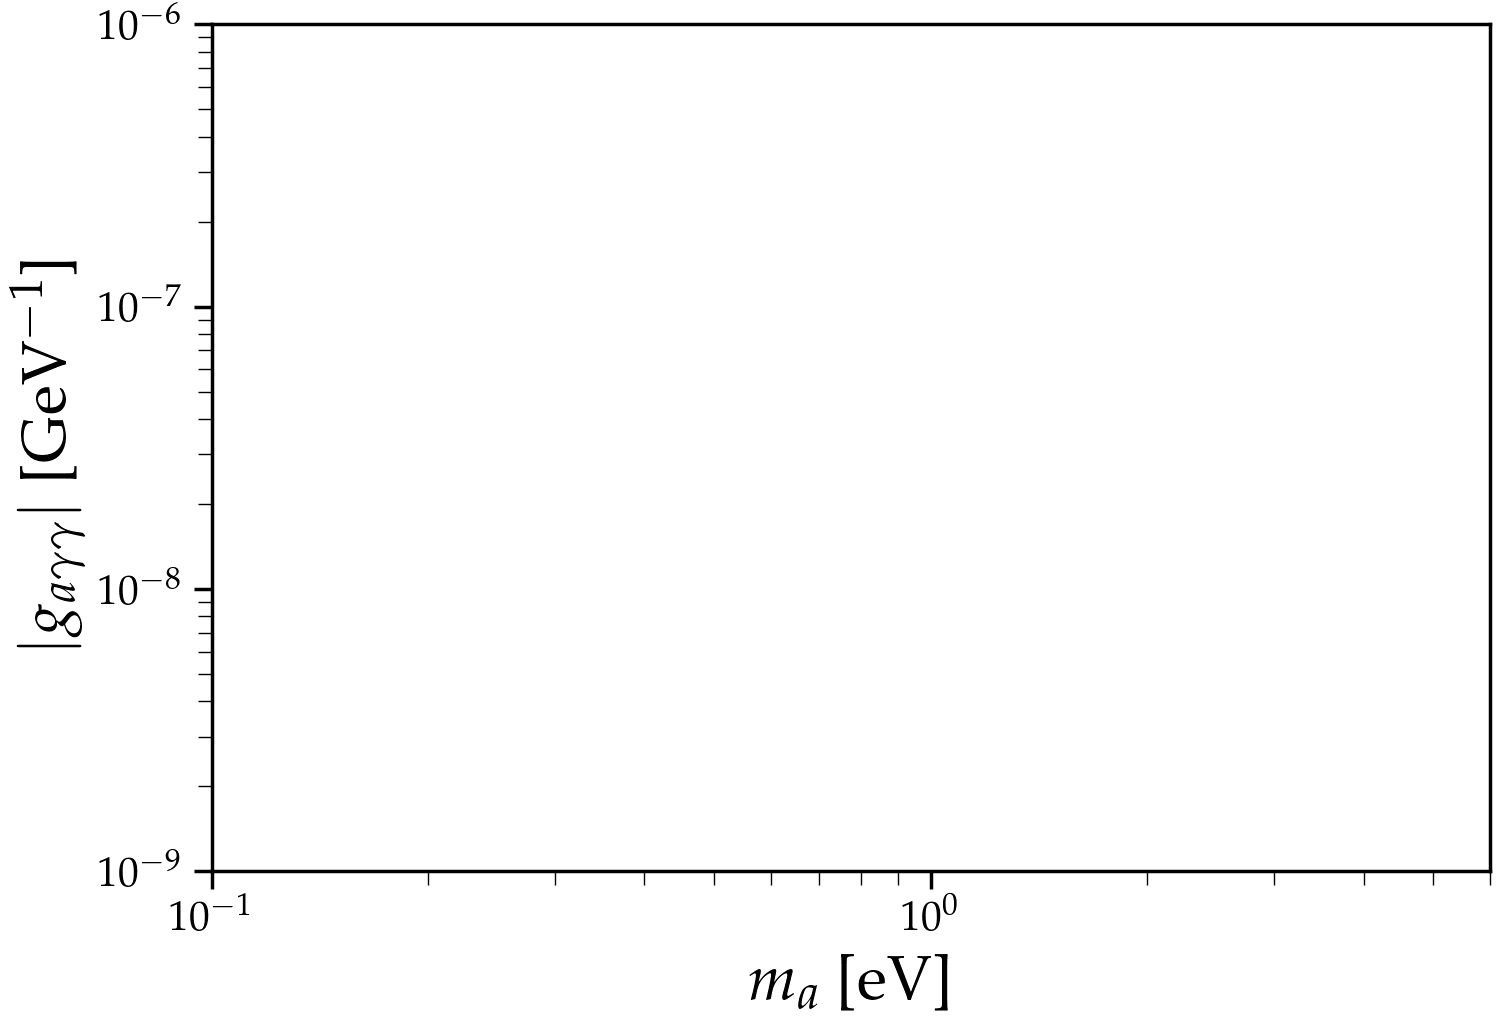

In [33]:
# plotting critical energy against g and ma
fig,ax = FigSetup(Shape='Rectangular',ylab='$|g_{a\gamma\gamma}|$ [GeV$^{-1}$]',mathpazo=True,xtick_rotation=0,tfs=30,\
                 m_min=0.1,m_max=6,g_min=1e-9,g_max=1e-6)
# setting g and ma list
glist = np.linspace(0.1, 6, 100)
malist = np.logspace(-9, -6, 100)
G, M = np.meshgrid(glist, malist)
Eclist = np.array(Ecritlist(np.ravel(G), np.ravel(M)))
Ec = Eclist.reshape(G.shape)

contour = plt.contourf(G, M, Ec, norm=colors.LogNorm(vmin=Ec.min(), vmax=Ec.max()), cmap='bwr')
plt.colorbar(contour, label=r'$E_{crit}$' + ' '+ '(TeV)')
plt.axvline(2, color='black', linestyle='--',linewidth=3)
plt.axhline(1e-8, color='black', linestyle='--',linewidth=3)
plt.yscale('log')
plt.xscale('linear')
plt.xlabel(r'$g_{a\gamma}$' + ' '+ r'($10^{-11}$ GeV$^{-1}$)')
plt.ylabel(r'$m_{a}$'+' '+'(eV)')
plt.title('Critical Conversion Energy')

<>:2: SyntaxWarning: invalid escape sequence '\g'
<>:2: SyntaxWarning: invalid escape sequence '\g'
C:\Users\Yuchong Chen\AppData\Local\Temp\ipykernel_50656\2742777141.py:2: SyntaxWarning: invalid escape sequence '\g'
  fig,ax = FigSetup(Shape='Rectangular',ylab='$|g_{a\gamma\gamma}|$ [GeV$^{-1}$]',mathpazo=True,xtick_rotation=0,tfs=30,\


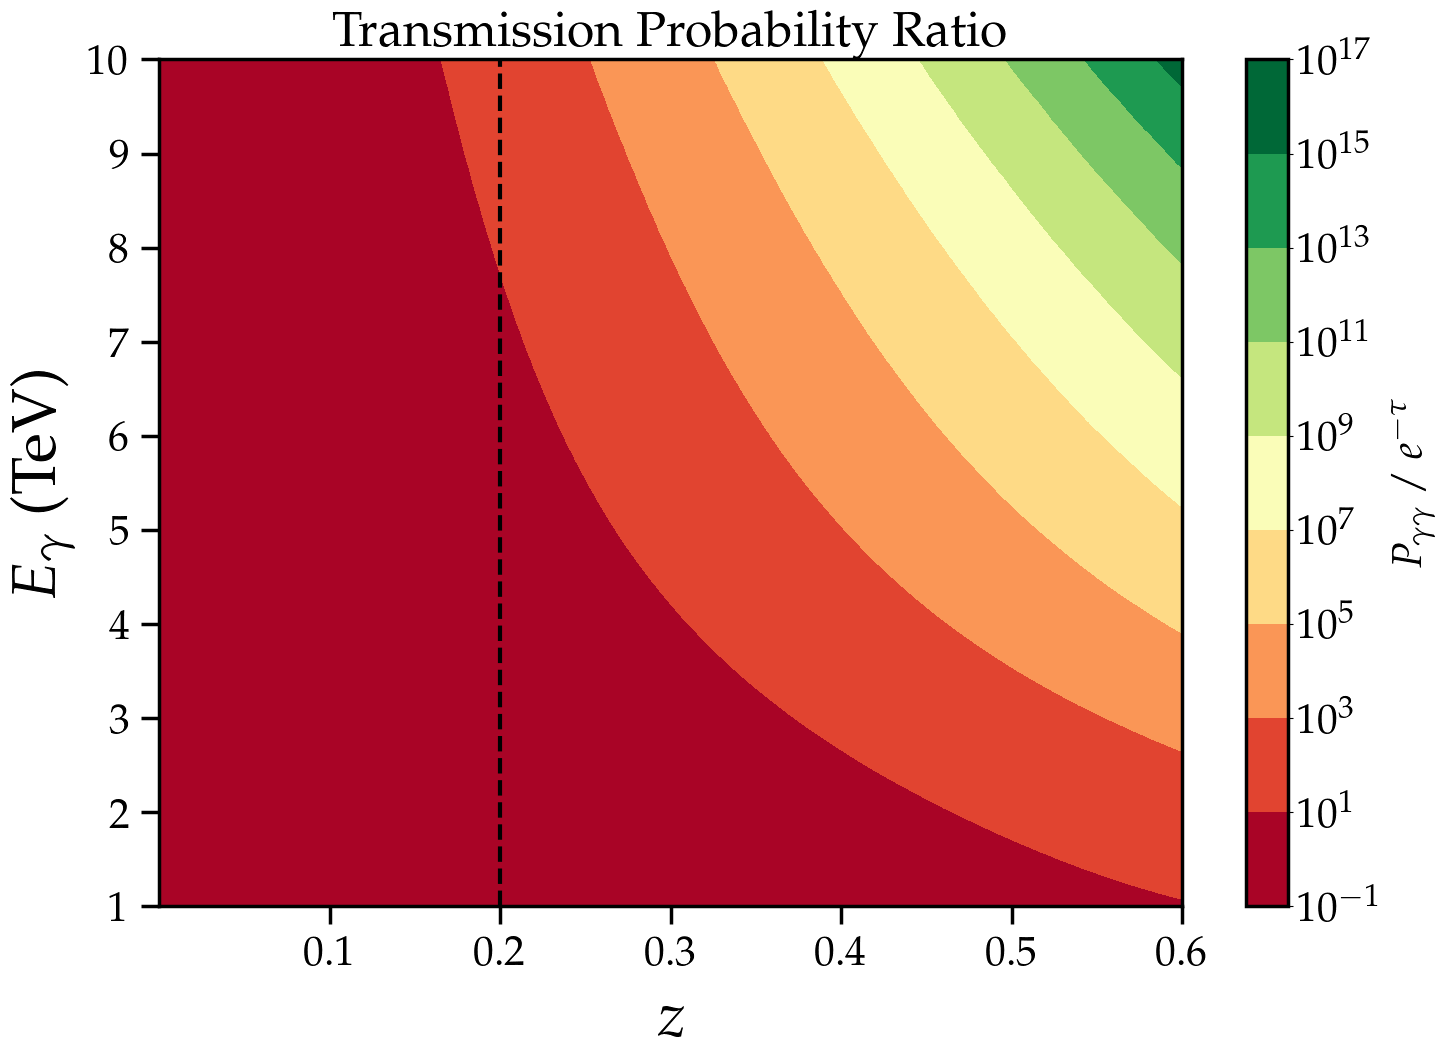

In [8]:
# 3D graphing for optimal redshift and energy interval
fig,ax = FigSetup(Shape='Rectangular',ylab='$|g_{a\gamma\gamma}|$ [GeV$^{-1}$]',mathpazo=True,xtick_rotation=0,tfs=30,\
                 m_min=0.0001,m_max=0.6,g_min=1,g_max=10)
# setting up redshift and energy list and source list
zlist = np.linspace(0, 0.6, 100)
Elist = np.linspace(1, 10, 100)
sourcelist = []
for i in range(len(zlist)):
    sourcelist.append(Source(None, None, None, None, None, 5*10**(-6), 3, zlist[i], None))

# meshgrid
Z, E= np.meshgrid(zlist, Elist)
S, EE = np.meshgrid(sourcelist, Elist)
ALPproblist = np.array(probEsourcearray(2, 0.01)(np.ravel(E), np.ravel(S)))
woALPproblist = np.array(EBLarray(np.ravel(E), np.ravel(S)))
A = ALPproblist.reshape(S.shape)
W = woALPproblist.reshape(S.shape)

contour = plt.contourf(Z, E, A/W, norm=colors.LogNorm(vmin=(A/W).min(), vmax=(A/W).max()), cmap='RdYlGn')
plt.colorbar(contour, label=r'$P_{\gamma\gamma}$' + ' ' + '/' + ' ' + r'$e^{-\tau}$')
#plt.axhline(0.5, color='black', linestyle='--', linewidth=3)
plt.axvline(0.2, color='black', linestyle='--', linewidth=3)
#plt.axvline(0.8, color='black', linestyle='--', linewidth=3)
plt.xlabel(r'$z$')
plt.ylabel(r'$E_{\gamma}$' + ' ' + '(TeV)')
plt.title('Transmission Probability Ratio ')
plt.xscale('linear')
plt.yscale('linear')


In [9]:
zlist = np.linspace(0.01, 1, 100)
sourcelist = []
for z in zlist:
    sourcelist.append(Source(None, None, None, None, None, 5*10**(-6), 3, z, None))

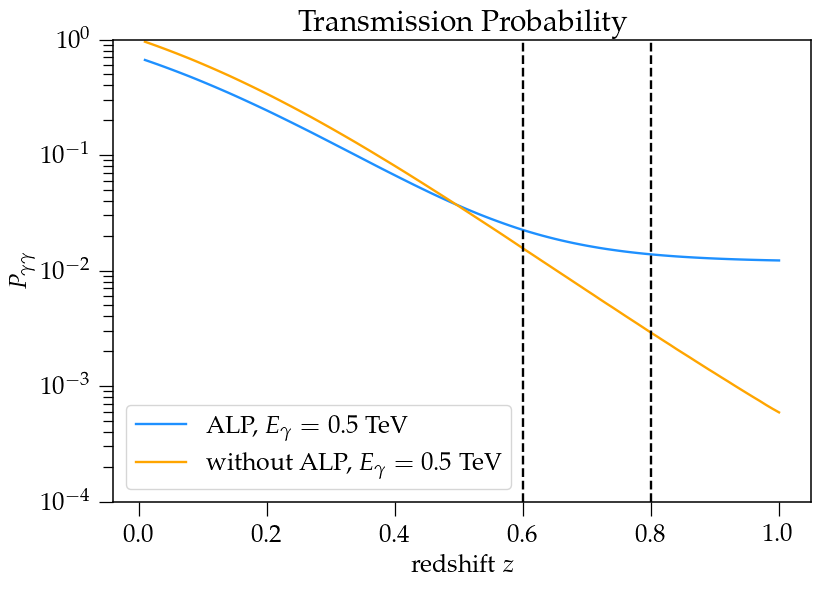

In [10]:
# 2D graphing for optimal redshift interval
Et1 = 0.5
plt.rcParams['axes.linewidth']=1.1
plt.rc('font', family='serif', size=18)
fig = plt.figure(figsize=(9,6))
ax = fig.add_subplot(111)
ax.plot(zlist, list(map(probsource(2, 0.01, Et1), sourcelist)), label='ALP, ' + r'$E_{\gamma} = 0.5$' + ' TeV', lw=1.7, color='dodgerblue')
ax.plot(zlist, list(map(EBLsource(Et1), sourcelist)), label='without ALP, ' r'$E_{\gamma} = 0.5$' +' TeV', lw=1.7, color='orange')
ax.axvline(0.6, color='black', linestyle='--',linewidth=1.7)
ax.axvline(0.8, color='black', linestyle='--', linewidth=1.7)
ax.set_xlabel('redshift' + ' ' + r'$z$')
ax.set_ylabel(r'$P_{\gamma\gamma}$')
ax.set_yscale('log')
ax.legend()
ax.set_title('Transmission Probability')
ax.set_ylim(1e-4, 1)
ax.tick_params(which='major',direction='out',width=0.9,length=10,right=False,top=False,pad=6)
ax.tick_params(which='minor',direction='out',width=0.9,length=7,right=False,top=False)


<>:2: SyntaxWarning: invalid escape sequence '\g'
<>:2: SyntaxWarning: invalid escape sequence '\g'
C:\Users\Yuchong Chen\AppData\Local\Temp\ipykernel_50656\3988944671.py:2: SyntaxWarning: invalid escape sequence '\g'
  fig,ax = FigSetup(Shape='Rectangular',ylab='$|g_{a\gamma\gamma}|$ [GeV$^{-1}$]',mathpazo=True,xtick_rotation=0,tfs=30,\


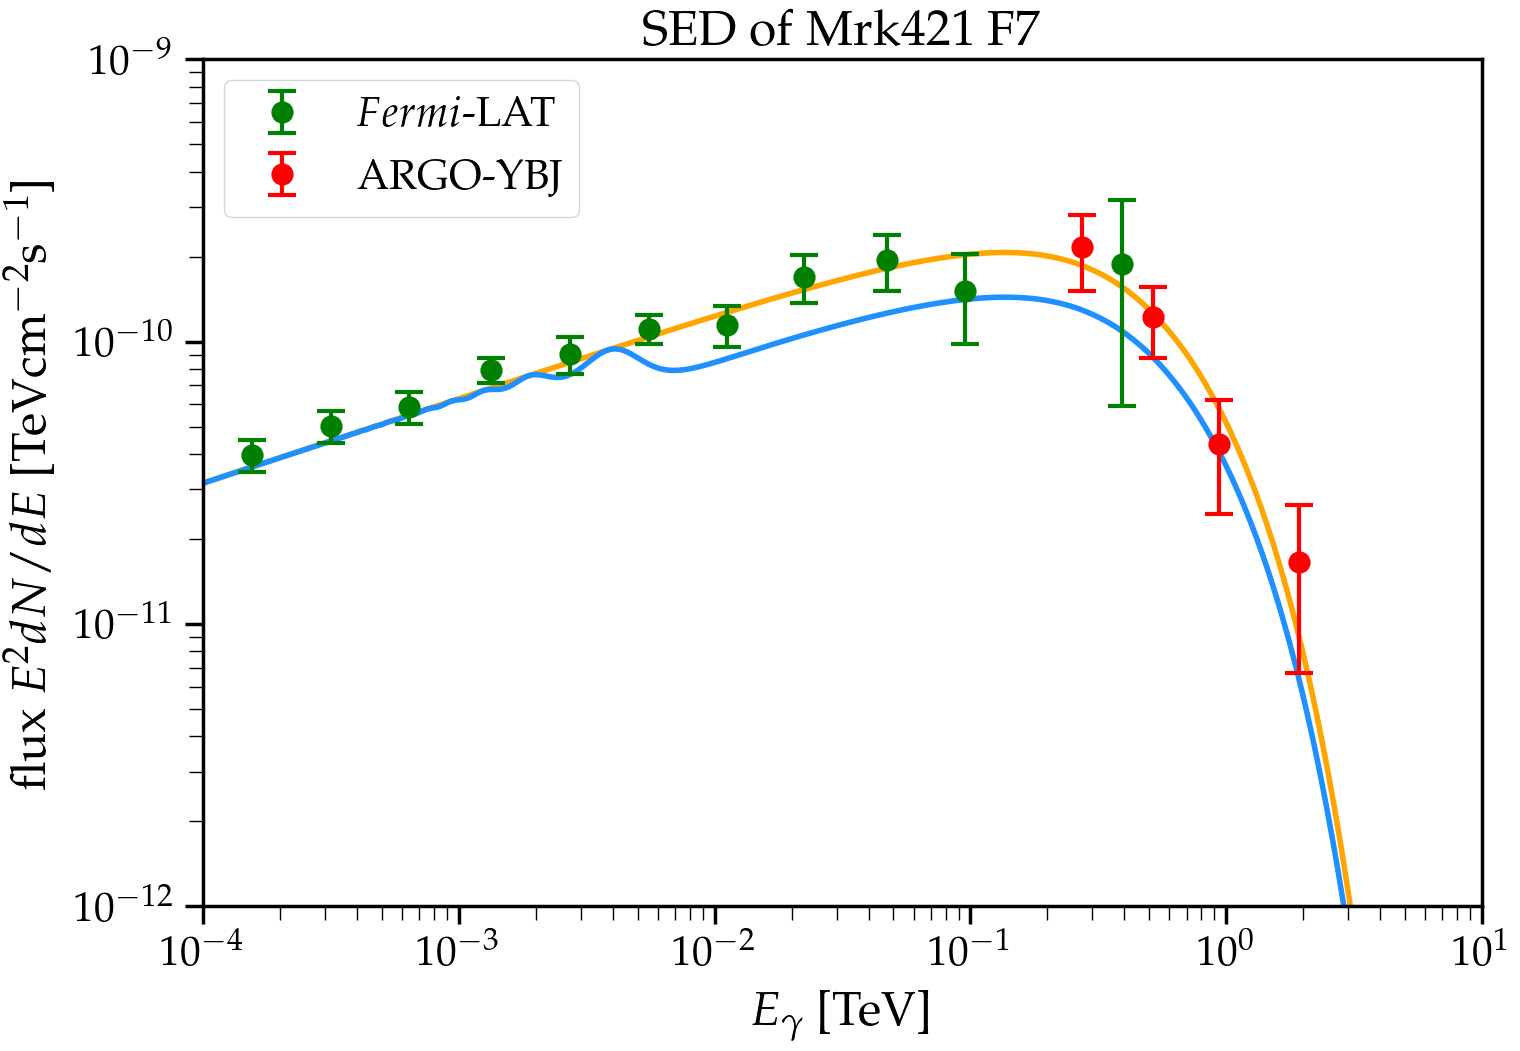

In [11]:
# reading file for Mrk 421 F7
fig,ax = FigSetup(Shape='Rectangular',ylab='$|g_{a\gamma\gamma}|$ [GeV$^{-1}$]',mathpazo=True,xtick_rotation=0,tfs=30,\
                lfs=35, m_min=1e-4,m_max=1e1,g_min=1e-12,g_max=1e-9)
Mrk421_F7ARGO = generate_source(
    str=r"C:\Users\Yuchong Chen\OneDrive\文档\科研\LHAASO_AGN_APL\数据处理\Mrk 421\Mrk 421 F7 data.xlsx",
    name='Mrk421 F7',
    sheet_name="Mrk 421 F7 ARGO",
    B=5e-6,
    r=3,
    z=0.031
)
Mrk421_F7Fermi = generate_source(
    str=r"C:\Users\Yuchong Chen\OneDrive\文档\科研\LHAASO_AGN_APL\数据处理\Mrk 421\Mrk 421 F7 data.xlsx",
    name='Mrk421 F7',
    sheet_name="Mrk 421 F7 Fermi",
    B=5e-6,
    r=3,
    z=0.031
)
Mrk421_F7 = combine_source([Mrk421_F7ARGO, Mrk421_F7Fermi])
x = np.logspace(-4, 1, 1000)
Mrk421_F7clone = generate_source(None, 'Mrk421 clone', B=5e-6, r=3, z=0.031, clone=True, x=x)
plt.plot(x, received_spectrum_wo(5e2, 1.7, 0.5, Mrk421_F7clone), lw=4, color='orange')#, label='without ALP theory')
plt.plot(x, received_spectrum(5e2, 1.7, 0.5, 3, 0.01, Mrk421_F7clone), lw=4, color='dodgerblue')#, label=r'$g_{a\gamma}=3$'+', '+r'$m_{a}=0.01$')
Mrk421_F7Fermi.plotenergy(ax=ax, color='g', label=r'$Fermi$'+'-LAT')
Mrk421_F7ARGO.plotenergy(ax=ax, color='r', label='ARGO-YBJ')
#plt.ylim(10**(-11.7), 10**(-9))

In [8]:
# reading file for B2 2234+28A
B2A_Fermi = generate_source(
    str=r"C:\Users\Yuchong Chen\OneDrive\文档\科研\LHAASO_AGN_APL\数据处理\B2 2234+28A\B2 223428A data.xlsx",
    name='B2 2234+28A',
    sheet_name='Fermi',
    B=5e-6, 
    r=3, 
    z=0.79
    )
B2A_MAGIC = generate_source(
    str=r"C:\Users\Yuchong Chen\OneDrive\文档\科研\LHAASO_AGN_APL\数据处理\B2 2234+28A\B2 223428A data.xlsx",
    name='B2 2234+28A',
    sheet_name='MAGIC',
    B=5e-6,
    r=3,
    z=0.79
)
B2A=combine_source([B2A_Fermi, B2A_MAGIC])

# removing a abnormal point
#B2A.fluxarray.pop(4)
#B2A.Earray.pop(4)
#B2A.dfluxarray.pop(4)
#B2A.dfluxarrayup.pop(4)



x = np.logspace(-3.3, 0, 1000)
B2Aclone = generate_source(None, 'B2 2234+28A', B=5e-6, r=3, z=0.79, clone=True, x=x)

B2Adominguez = generate_source(None, 'B2 2234+28A', B=5e-6, r=3, z=0.79, clone=True, x=x)
B2Asaldana = generate_source(None, 'B2 2234+28A', B=5e-6, r=3, z=0.79, clone=True, x=x)
B2Agilmore = generate_source(None, 'B2 2234+28A', B=5e-6, r=3, z=0.79, clone=True, x=x)
B2Aclone.tau = OptDepth.readmodel(model='finke2022')
B2Adominguez.tau = OptDepth.readmodel(model='dominguez-upper')
B2Asaldana.tau= OptDepth.readmodel(model='saldana-lopez')
B2Agilmore.tau = OptDepth.readmodel(model='gilmore')

<>:2: SyntaxWarning: invalid escape sequence '\g'
<>:2: SyntaxWarning: invalid escape sequence '\g'
C:\Users\Yuchong Chen\AppData\Local\Temp\ipykernel_29184\321099821.py:2: SyntaxWarning: invalid escape sequence '\g'
  fig,ax = FigSetup(Shape='Rectangular',ylab='$|g_{a\gamma\gamma}|$ [GeV$^{-1}$]',mathpazo=True,xtick_rotation=0,tfs=30,\


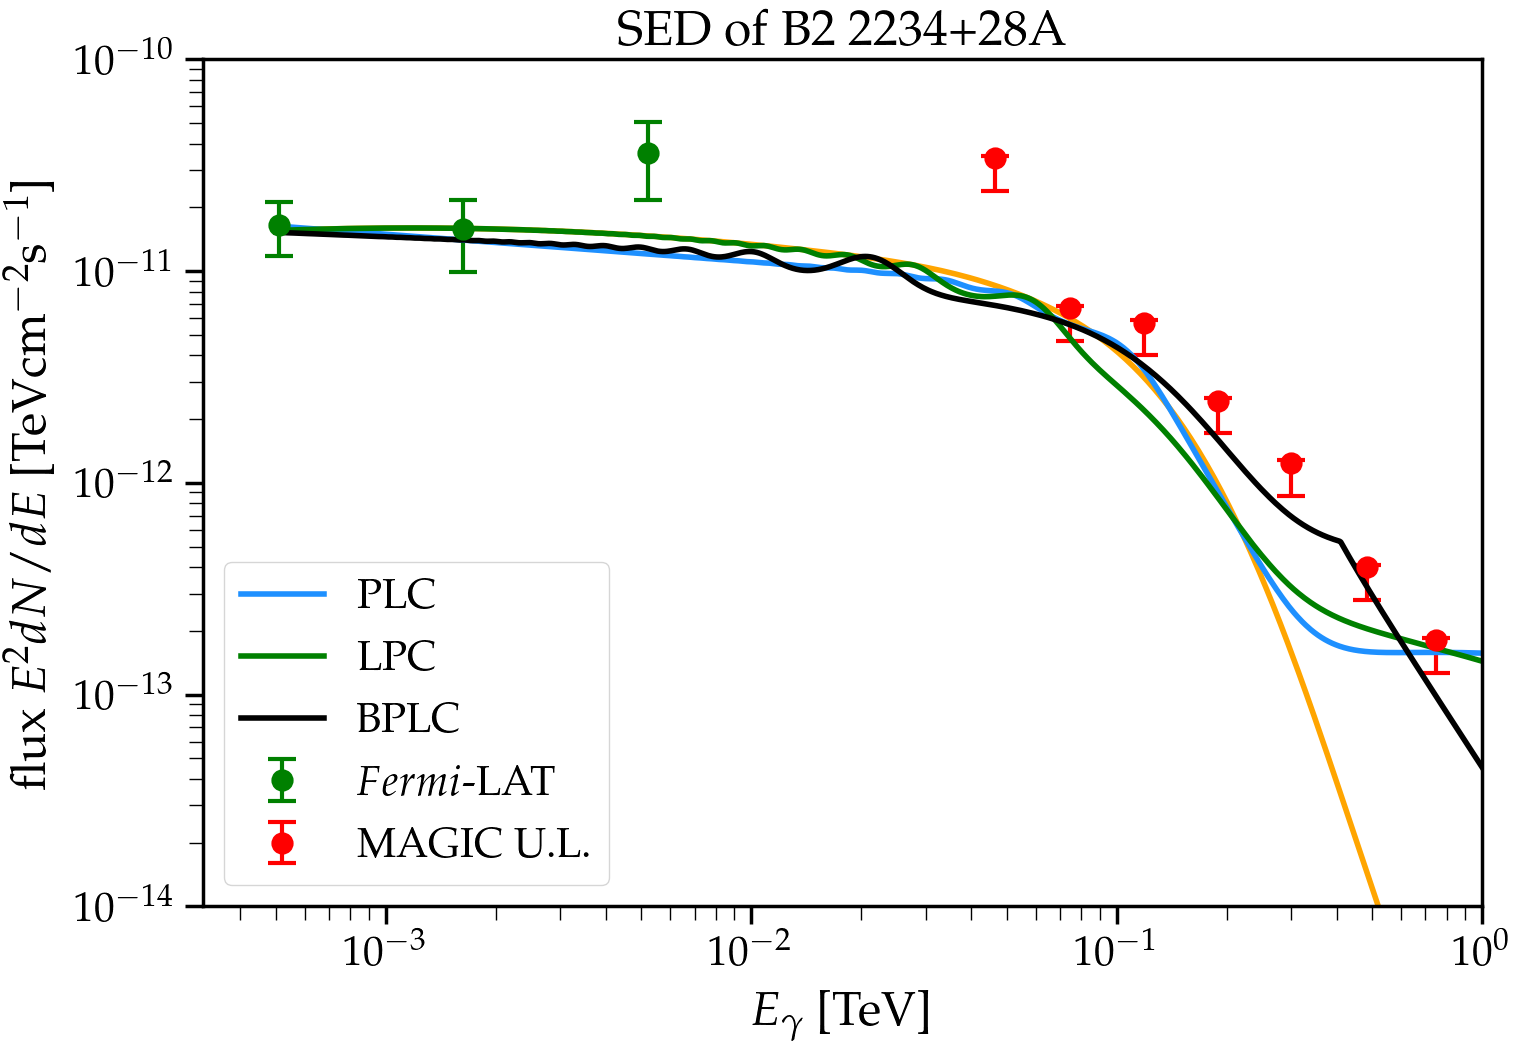

In [9]:
# plotting B2A SED
fig,ax = FigSetup(Shape='Rectangular',ylab='$|g_{a\gamma\gamma}|$ [GeV$^{-1}$]',mathpazo=True,xtick_rotation=0,tfs=30,\
                lfs=35, m_min=10**(-3.5),m_max=1e0,g_min=1e-14,g_max=1e-10)

B2A_Fermi.plotenergy(ax=ax, color='g', label=r'$Fermi$'+'-LAT')
B2A_MAGIC.plotenergy(ax=ax, color='r', upper_error_fraction=0.1, lower_error_fraction=1, label='MAGIC U.L.')

plt.loglog(x, rswo(2.76, 2.52, 3.85, source=B2Aclone, powerlaw=ini_spectrum_LPC), lw=4, color='orange')# label='without ALP')
#plt.plot(x, rs(6.08, 2.102, 20, g=3.06, ma=0.054, source=B2Aclone), lw=4, color='dodgerblue', label='PLC')# label=r'$g = 3.05$' + ', ' + r'$m_{a}=0.0525$')
plt.plot(x, rs(6.08, 2.13, 47, g=3.05, ma=0.052, source=B2Aclone), lw=4, color='dodgerblue', label='PLC')# label=r'$g = 3.05$' + ', ' + r'$m_{a}=0.0525$')


#plt.plot(x, rs(4, 2.55, 5.21, g=3.55, ma=0.039, source=B2Agilmore, powerlaw=ini_spectrum_LPC), lw=4, color='g', label='gilmore')
#plt.plot(x, rs(4, 2.55, 5.21, g=3.55, ma=0.039, source=B2Adominguez, powerlaw=ini_spectrum_LPC), lw=4, color='black', label='dominguez')
plt.plot(x, rs(2.76, 2.52, 3.85, g=4.35, ma=0.0382, source=B2Aclone, powerlaw=ini_spectrum_LPC), lw=4, color='g', label='LPC')

#plt.plot(x, rs(4, 2.05, 4.89, 0.47, g=3.55, ma=0.039, source=B2Aclone, powerlaw=ini_spectrum_BPLC), lw=4, color='black', label='BPLC')
plt.plot(x, rs(5.67, 2.07, 4.65, 0.41, g=4.25, ma=0.023, source=B2Aclone, powerlaw=ini_spectrum_BPLC), lw=4, color='black', label='BPLC')
plt.legend()

In [27]:
# reading file for 3C 454.3
C3454_Fermi = generate_source(
    str=r"C:\Users\Yuchong Chen\OneDrive\文档\科研\LHAASO_AGN_APL\数据处理\3C 4543\3C 4543.xlsx",
    name='3C 454.3', 
    sheet_name='Fermi',
    B=5e-6, 
    r=3, 
    z=0.859
    )
C3454_MAGIC = generate_source(
    str=r"C:\Users\Yuchong Chen\OneDrive\文档\科研\LHAASO_AGN_APL\数据处理\3C 4543\3C 4543.xlsx",
    name='3C 454.3', 
    sheet_name='MAGIC',
    B=5e-6, 
    r=3, 
    z=0.859
    )
C3454 = combine_source([C3454_Fermi, C3454_MAGIC])
C3454clone = generate_source(None, '3C 454.3 clone', B=5e-6, r=3, z=0.859, clone=True, x=x)
C3454gilmore = generate_source(None, '3C 454.3 clone', B=5e-6, r=3, z=0.859, clone=True, x=x)
C3454dominguez = generate_source(None, '3C 454.3 clone', B=5e-6, r=3, z=0.859, clone=True, x=x)
C3454clone.tau = OptDepth.readmodel(model='finke2022')
C3454gilmore.tau = OptDepth.readmodel(model='gilmore')
C3454dominguez.tau = OptDepth.readmodel(model='dominguez')

100%|██████████| 500/500 [00:17<00:00, 27.98it/s]


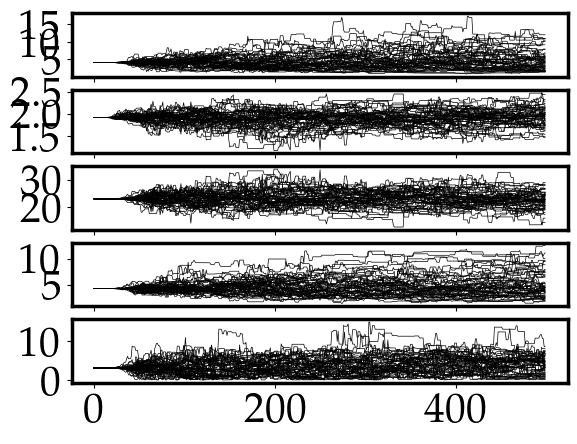

array([[ 3.54255088,  1.84023467, 24.35501344,  4.62379035,  1.20772328],
       [ 5.15914777,  1.83107499, 24.99116783,  3.88727717,  4.90128103],
       [ 4.3046281 ,  2.07442681, 19.78567415,  4.26778112,  4.74074203],
       ...,
       [ 6.04693675,  1.84345601, 24.95332759,  3.51864391,  4.5458466 ],
       [ 5.64325042,  1.68547915, 25.58989659,  2.80481606,  0.24821697],
       [ 1.64227763,  2.32270863, 16.08230419,  9.98743217,  4.70969937]])

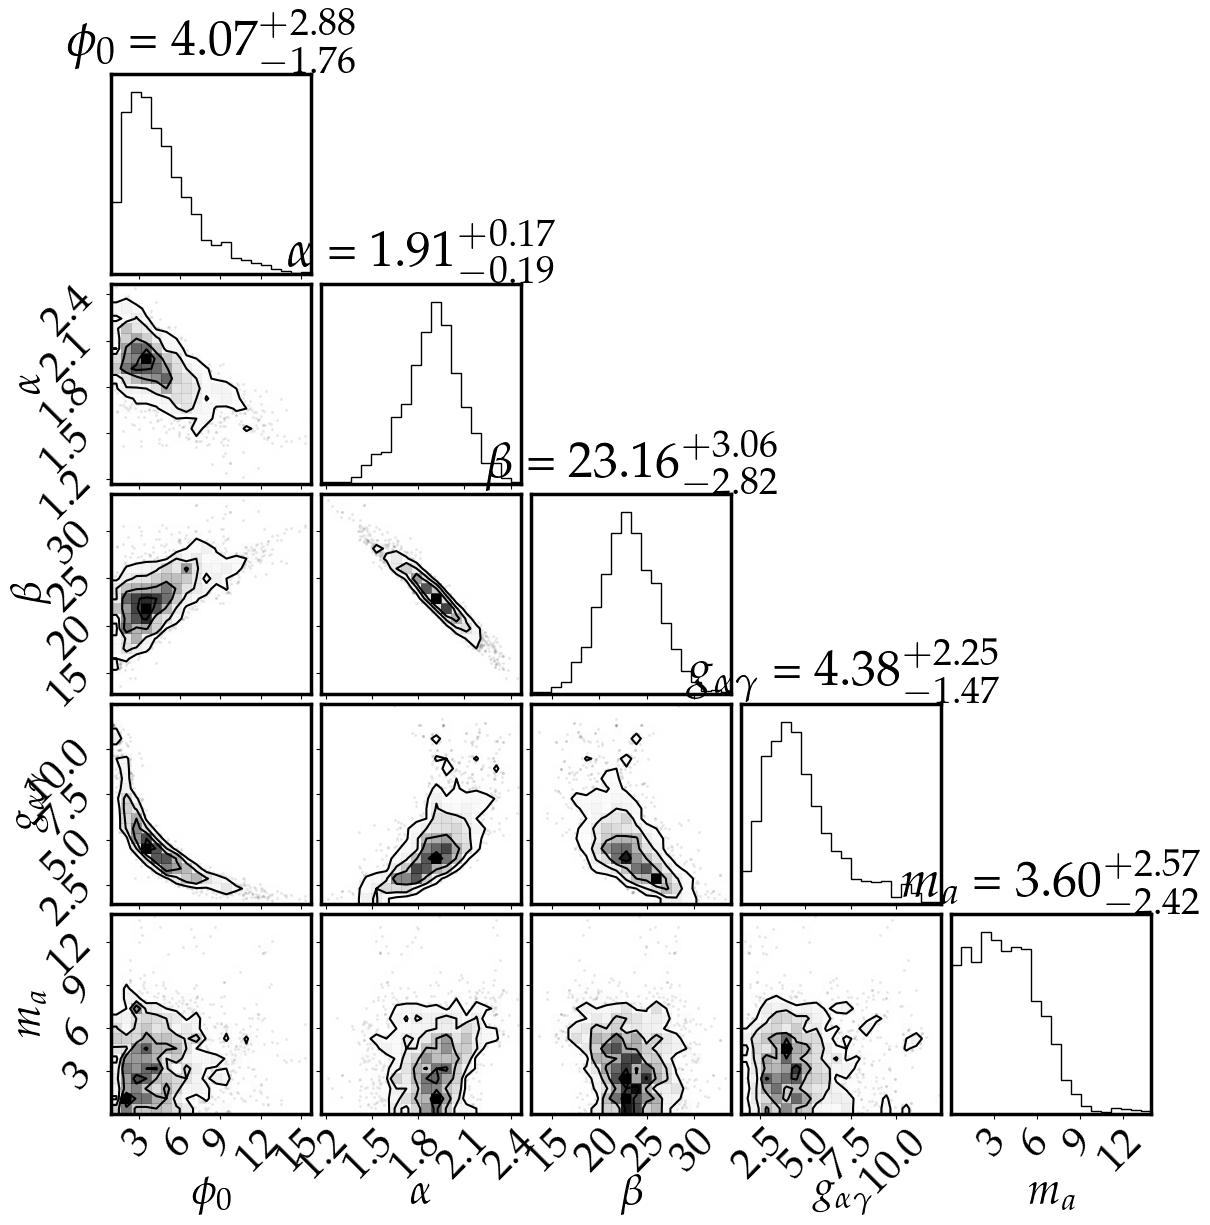

In [176]:
#['g', 'ma']
#['phin', 'alpha', 'beta', 'Ec']
#['phin', 'gamma1', 'gamma2', 'Ebreak', 'Ec']
C3454.MCMC(
    ini_guess=[4.15, 1.92, 23.14, 4.27, 3.08],
    intrinsic_par=[2.76, 2.52, 3.85],
    powerlaw=ini_spectrum_LPC,
    var_strlist=['phin', 'alpha', 'beta', 'g', 'ma'],
    testing=2
)

<>:2: SyntaxWarning: invalid escape sequence '\g'
<>:2: SyntaxWarning: invalid escape sequence '\g'
C:\Users\Yuchong Chen\AppData\Local\Temp\ipykernel_29184\1032085004.py:2: SyntaxWarning: invalid escape sequence '\g'
  fig,ax = FigSetup(Shape='Rectangular',ylab='$|g_{a\gamma\gamma}|$ [GeV$^{-1}$]',mathpazo=True,xtick_rotation=0,tfs=30,\


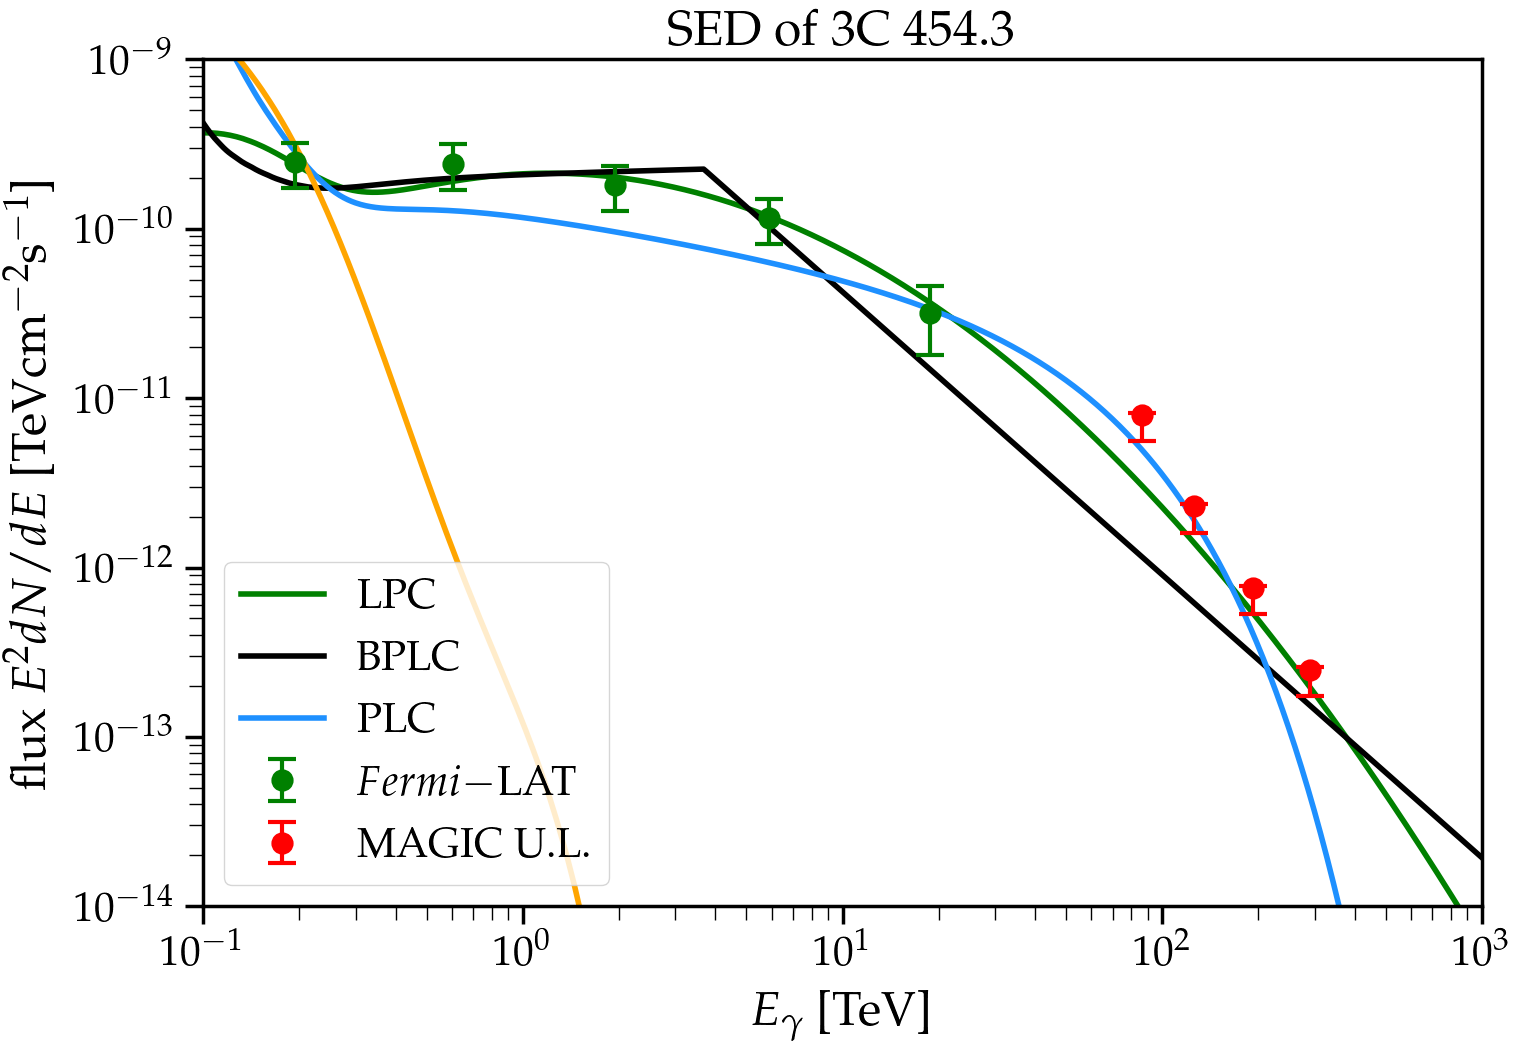

In [64]:
# plotting 3C 454.3 SED
fig,ax = FigSetup(Shape='Rectangular',ylab='$|g_{a\gamma\gamma}|$ [GeV$^{-1}$]',mathpazo=True,xtick_rotation=0,tfs=30,\
                lfs=35, m_min=1e-1,m_max=1e3,g_min=1e-14,g_max=1e-9)
x = np.logspace(-1, 3.0, 1000)

#plt.loglog(x, rs(3.89, 1.92, 22.82, g=4.47, ma=0.0342, source=C3454gilmore, powerlaw=ini_spectrum_LPC),lw=4, color='g', label='gilmore')
#plt.loglog(x, rs(3.89, 1.92, 22.82, g=4.47, ma=0.0342, source=C3454dominguez, powerlaw=ini_spectrum_LPC),lw=4, color='black', label='dominguez')
plt.loglog(x, rs(4.15, 1.92, 23.14, g=4.27, ma=0.0308, source=C3454clone, powerlaw=ini_spectrum_LPC),lw=4, color='g', label='LPC')

#plt.loglog(x, rs(2.75, 2, 3.89, 8.81, g=5.05, ma=0.036, source=C3454gilmore, powerlaw=ini_spectrum_BPLC),lw=4, color='black', label='BPLC')# label='ALP ' + r'$g=7.4$' + ' ' +r'$m_{a}=0.055$')
plt.loglog(x, rs(10.98, 1.95, 3.67, 3.68, g=9.02, ma=0.0409, source=C3454gilmore, powerlaw=ini_spectrum_BPLC),lw=4, color='black', label='BPLC')# label='ALP ' + r'$g=7.4$' + ' ' +r'$m_{a}=0.055$')

plt.loglog(x, received_spectrum(1.81, 2.31, 47, 5.08, 0.0505, C3454clone),lw=4, color='dodgerblue', label='PLC')

plt.loglog(x, received_spectrum_wo(1.49, 2.34, 45.64, C3454clone), lw=4, color='orange')#label='without ALP')
C3454_Fermi.plotenergy(ax=ax, color='g', label=r'$Fermi-$LAT')
C3454_MAGIC.plotenergy(ax=ax, color='r', upper_error_fraction=0.1, lower_error_fraction=1, label='MAGIC U.L.')
ax.legend(loc='lower left')

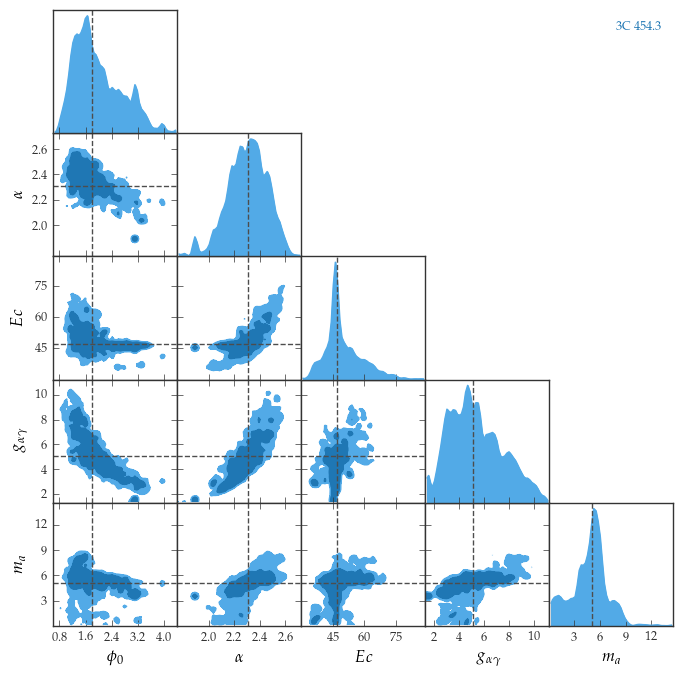

In [60]:
names = [r'$\phi_{0}$', r'$\alpha$', r'$Ec$', r'$g_{\alpha\gamma}$', r'$m_{a}$']
truths = (1.81, 2.31, 47, 5.08, 5.05)
g = pygtc.plotGTC(chains=C3454.flat_samples, figureSize=8.0, paramNames = names, \
                  customLabelFont={'family':'Arial', 'size':12}, \
                  customTickFont={'family':'Arial', 'size':9}, nBins=60, smoothingKernel=1, \
                  labelRotation=(False, False), truths=truths, chainLabels=['3C 454.3'])

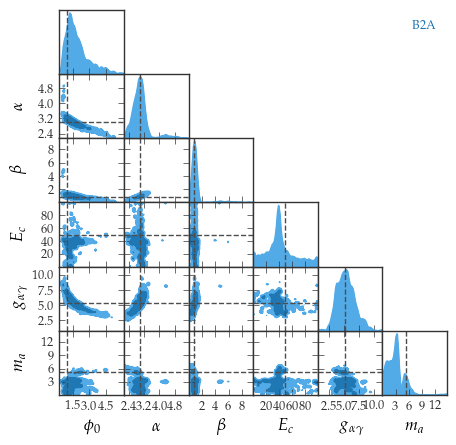

In [110]:
names = [r'$\phi_{0}$', r'$\alpha$', r'$\beta$',  r'$E_{c}$', r'$g_{\alpha\gamma}$', r'$m_{a}$']
truths = (1, 3, 0.88, 49, 5.29, 5.25)
g = pygtc.plotGTC(chains=test.flat_samples, figureSize=5.0, \
                  customLabelFont={'family':'Arial', 'size':12}, \
                  customTickFont={'family':'Arial', 'size':9}, nBins=60, smoothingKernel=1, \
                  labelRotation=(False, False), chainLabels=['B2A'], paramNames=names, truths=truths)

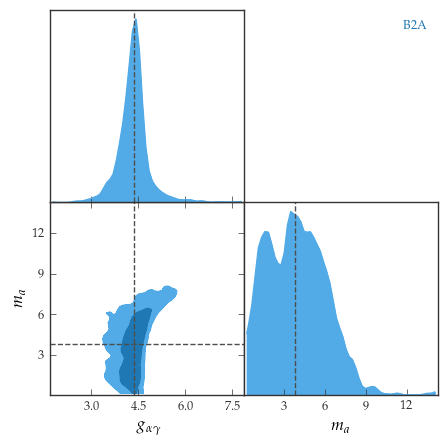

In [266]:
names = [r'$g_{\alpha\gamma}$', r'$m_{a}$']
truths = (4.35, 3.82)
g = pygtc.plotGTC(chains=B2A.flat_samples, figureSize=5.0, \
                  customLabelFont={'family':'Arial', 'size':12}, \
                  customTickFont={'family':'Arial', 'size':9}, nBins=60, smoothingKernel=1, \
                  labelRotation=(False, False), chainLabels=['B2A'], paramNames=names, truths=truths)

<>:3: SyntaxWarning: invalid escape sequence '\g'
<>:12: SyntaxWarning: invalid escape sequence '\l'
<>:3: SyntaxWarning: invalid escape sequence '\g'
<>:12: SyntaxWarning: invalid escape sequence '\l'
C:\Users\Yuchong Chen\AppData\Local\Temp\ipykernel_29184\2147729295.py:3: SyntaxWarning: invalid escape sequence '\g'
  fig,ax = FigSetup(Shape='Rectangular',ylab='$|g_{a\gamma\gamma}|$ [GeV$^{-1}$]',mathpazo=True,xtick_rotation=0,tfs=30,\
C:\Users\Yuchong Chen\AppData\Local\Temp\ipykernel_29184\2147729295.py:12: SyntaxWarning: invalid escape sequence '\l'
  PlotBound(ax, "AxionLimits_master\limit_data\AxionPhoton\MAGIC.txt", facecolor='#68BD48', zorder=0.14)


<a list of 1 text.Text objects>

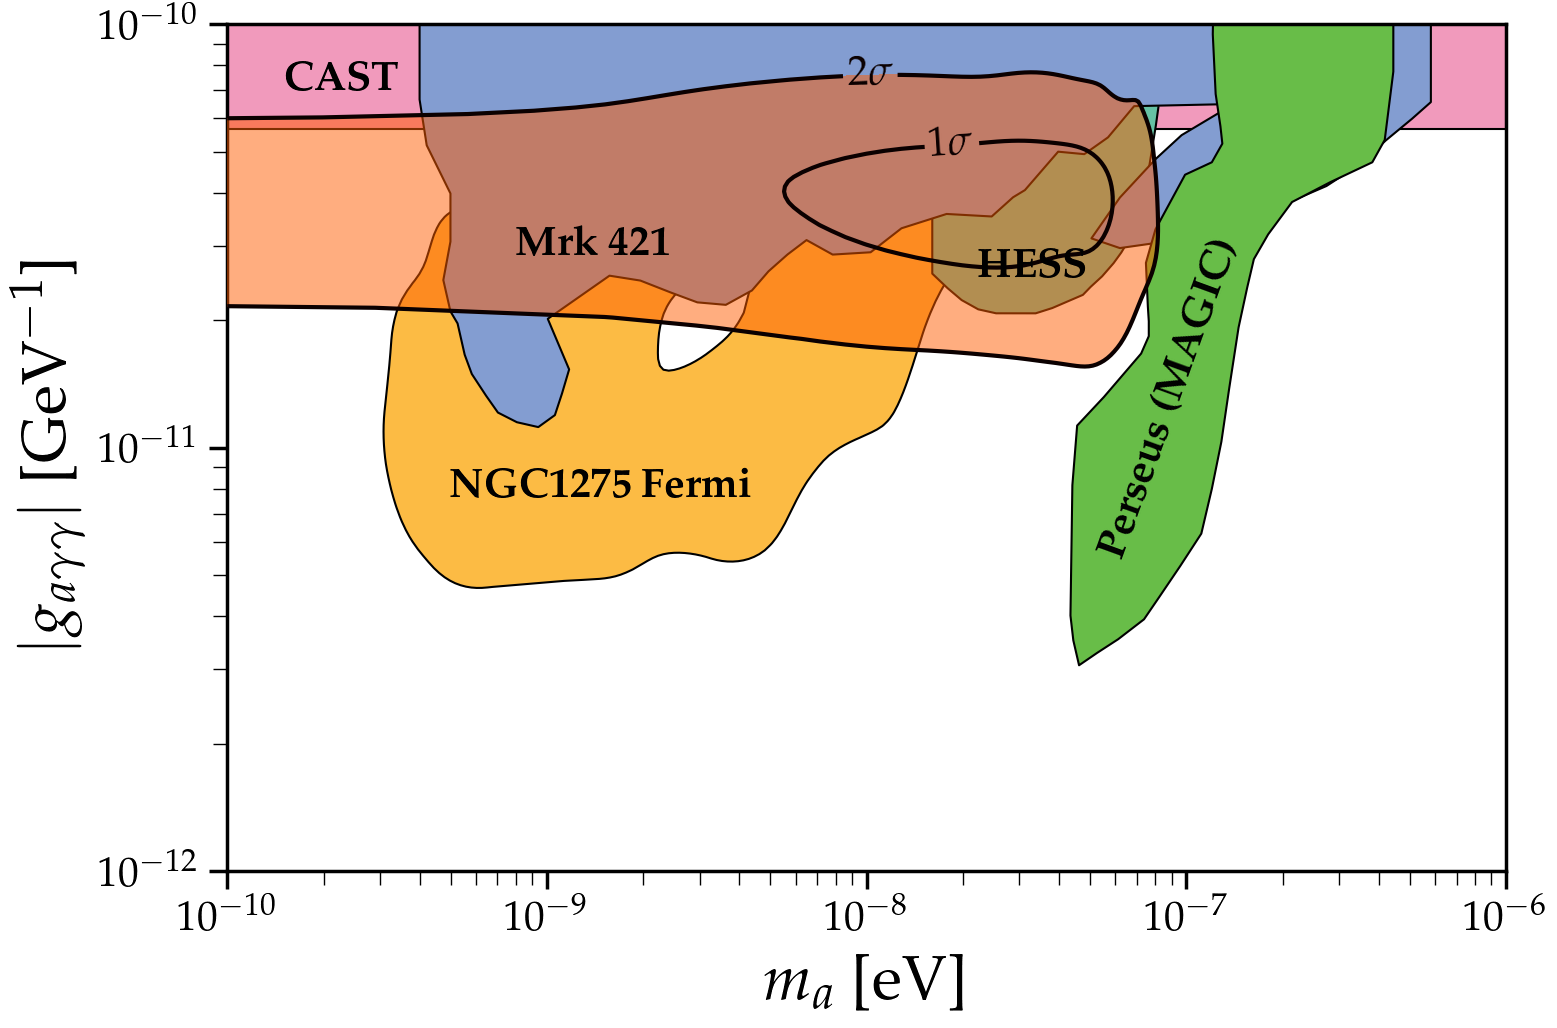

In [237]:
# CLs constraint with other results

fig,ax = FigSetup(Shape='Rectangular',ylab='$|g_{a\gamma\gamma}|$ [GeV$^{-1}$]',mathpazo=True,xtick_rotation=0,tfs=30,\
                 m_min=1e-10,m_max=1e-6,g_min=1e-12,g_max=1e-10)
#y2 = ax.get_ylim()[1]

PlotBound(ax, "AxionLimits_master/limit_data/AxionPhoton/Fermi_bound.txt", facecolor='#FCBB44', zorder=0.14)
PlotBound(ax, "AxionLimits_master/limit_data/AxionPhoton/Fermi_hole.txt", facecolor='w', zorder=0.14)
PlotBound(ax,"AxionLimits_master/limit_data/AxionPhoton/CAST.txt",facecolor='#F19ABC',zorder=0.14)
PlotBound(ax, "AxionLimits_master/limit_data/AxionPhoton/HESS.txt", facecolor='#66C1A4', zorder=0.14)
PlotBound(ax, "AxionLimits_master/limit_data/AxionPhoton/Mrk421.txt", facecolor='#839DD1', zorder=0.14)
PlotBound(ax, "AxionLimits_master\limit_data\AxionPhoton\MAGIC.txt", facecolor='#68BD48', zorder=0.14)



# Experiments
plt.gcf().text(0.16,0.82,r'{\bf CAST}')#,color='w',fontsize=30,rotation=0,rotation_mode='anchor',ha='center',va='center',path_effects=line_background(2.0,'k'))


# HESS
plt.gcf().text(0.58,0.65,r'{\bf HESS}')#,color='w',fontsize=20,rotation=0,rotation_mode='anchor',ha='center',va='center', path_effects=line_background(1.5, 'k'))

# Mrk 421
plt.gcf().text(0.3,0.67,r'{\bf Mrk 421}')#,color='w',fontsize=25,rotation=0,rotation_mode='anchor',ha='center',va='center',path_effects=line_background(1.5,'k'))

# Fermi
plt.gcf().text(0.26,0.45,r'{\bf NGC1275 Fermi}')#,color='w',fontsize=22,rotation=0,rotation_mode='anchor',ha='center',va='center',path_effects=line_background(1.5,'k'))

# MAGIC
plt.gcf().text(0.65, 0.4, r'{\bf Perseus (MAGIC)}', rotation=70)

# B2A
#parameter_scan(B2A_MAGIC, 2.76, 2.55, 3.85, powerlaw=ini_spectrum_LPC)
#plt.gcf().text(0.16, 0.7, r'{\bf B2A}')#, color='b', fontsize=26, rotation=0,rotation_mode='anchor',ha='center',va='center',path_effects=line_background(1.5,'k'))

# 3C 454.3
#parameter_scan(C3454, 3.89e3, 1.92, 22.82, color='crimson', powerlaw=ini_spectrum_LPC)
#plt.gcf().text(0.74, 0.78, r'{\bf 3C 454.3}')#, color='r', fontsize=26, rotation=0,rotation_mode='anchor',ha='center',va='center',path_effects=line_background(1.5,'k'))
#plt.xlabel(r'$m_{a}$ (eV)')\

m1 = C3454.flat_samples[:,4]*10**(-8)
m2 = C3454.flat_samples[:,3]*10**(-11)
xmin = 1e-10
xmax = m1.max()
ymin = m2.min()
ymax = m2.max()

X, Y = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
positions = np.vstack([X.ravel(), Y.ravel()])
values = np.vstack([m1, m2])
kernel = stats.gaussian_kde(values)
Z = np.reshape(kernel.evaluate(positions).T, X.shape)
#ax.contourf(X, Y, Z, levels=[2.5086833e+17, Z.max()], cmap='hot', zorder=5, alpha=0.5)
CS1=ax.contour(X, Y, Z, [2.5086833e+17], cmap='hot', zorder=10, linewidths=3)
ax.clabel(CS1, [2.5086833e+17,], fmt=r'$1\sigma$', inline=1)

ax.contourf(X, Y, Z, levels=[6.19028579e+16, Z.max()], cmap='hot', zorder=5, alpha=0.5)
CS2=ax.contour(X, Y, Z, [6.19028579e+16], cmap='hot', zorder=10, linewidths=3)
ax.clabel(CS2, [6.19028579e+16,], fmt=r'$2\sigma$', inline=1)



In [218]:
labels=[r'\phi_0', r'\alpha', r'\beta', r'g_{a\gamma}', r'm_a']
for i in range(5):
    mcmc = np.percentile(C3454.flat_samples[:, i], [2.3, 50, 97.7])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    display(Math(txt))

<>:5: SyntaxWarning: invalid escape sequence '\m'
<>:5: SyntaxWarning: invalid escape sequence '\m'
C:\Users\Yuchong Chen\AppData\Local\Temp\ipykernel_29184\2315067433.py:5: SyntaxWarning: invalid escape sequence '\m'
  txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<>:15: SyntaxWarning: invalid escape sequence '\g'
<>:15: SyntaxWarning: invalid escape sequence '\g'
C:\Users\Yuchong Chen\AppData\Local\Temp\ipykernel_29184\2984903912.py:15: SyntaxWarning: invalid escape sequence '\g'
  fig,ax = FigSetup(Shape='Rectangular',ylab='$|g_{a\gamma\gamma}|$ [GeV$^{-1}$]',mathpazo=True,xtick_rotation=0,tfs=30,\


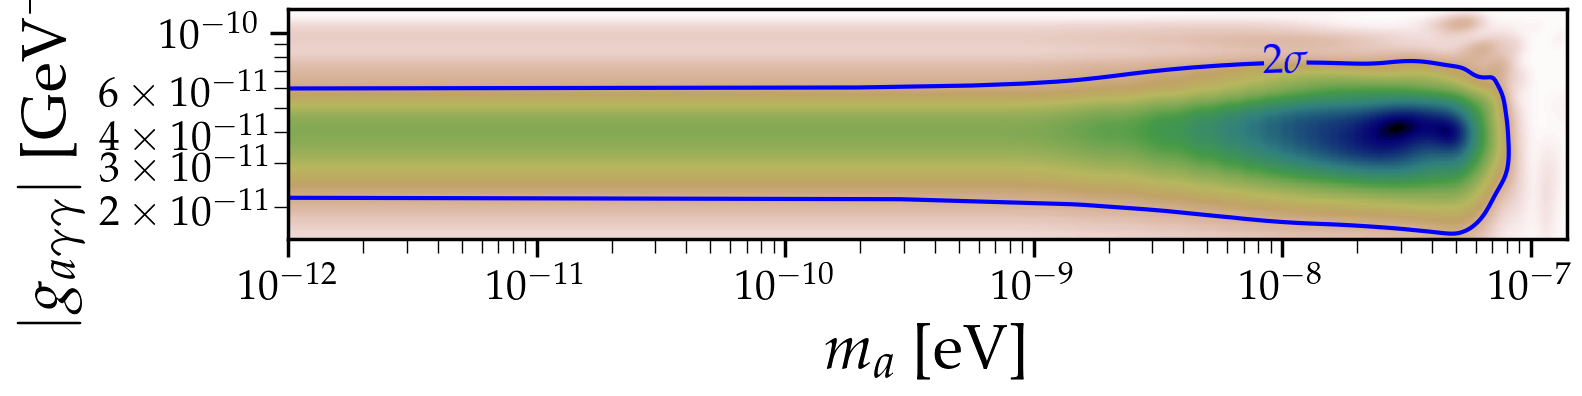

In [236]:

#m1, m2 = measure(2000)
m1 = C3454.flat_samples[:,4]*10**(-8)
m2 = C3454.flat_samples[:,3]*10**(-11)
xmin = 1e-12
xmax = m1.max()
ymin = m2.min()
ymax = m2.max()

X, Y = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
positions = np.vstack([X.ravel(), Y.ravel()])
values = np.vstack([m1, m2])
kernel = stats.gaussian_kde(values)
Z = np.reshape(kernel.evaluate(positions).T, X.shape)   # posterior array

fig,ax = FigSetup(Shape='Rectangular',ylab='$|g_{a\gamma\gamma}|$ [GeV$^{-1}$]',mathpazo=True,xtick_rotation=0,tfs=30,\
                 m_min=1e-10,m_max=1e-6,g_min=1e-12,g_max=1e-10)
ax.imshow(np.rot90(Z), cmap=plt.cm.gist_earth_r, extent=[xmin, xmax, ymin, ymax])
CS=ax.contour(X, Y, Z, [6.19028579e+16], cmap='bwr', linewidths=3)
ax.clabel(CS, [6.19028579e+16,], fmt=r'$2\sigma$', inline=1)
ax.set_xlim([xmin, xmax])
ax.set_ylim([ymin, ymax])
ax.set_xscale('log')
ax.set_yscale('log')
plt.show()

In [219]:
kernel.evaluate([(3.60-3.386)*10**(-8), (4.38-2.386)*10**(-11)])

array([6.19028579e+16])

In [195]:
kernel.evaluate([(3.60+2.57)*10**(-8), (4.38+2.25)*10**(-11)])

array([6.3047554e+16])

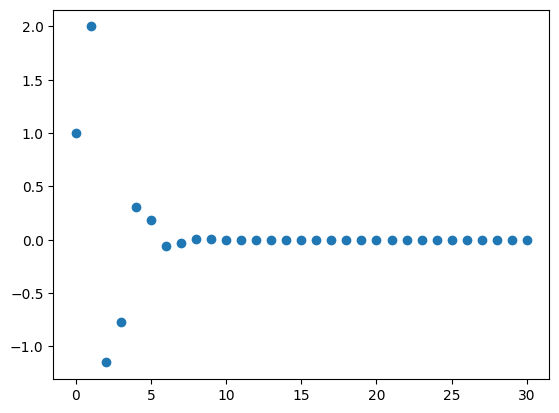

In [16]:
k=2.3
def recur(n):
    if n==0:
        return 1
    elif n==1:
        return 2
    elif n==2:
        return (-1/2)*k*recur(0)
    elif n==3:
        return (-1/6)*k*recur(1)
    else:
        return 1/(n*(n-1))*(recur(n-4)-k*recur(n-2))

x=np.linspace(0,30,31)
plt.scatter(x,[recur(i) for i in x])

In [17]:
recur(30)

-1.110529382317516e-16